<a href="https://colab.research.google.com/github/Shujaat123/SADIA_KFUPM_JRCAI_Workshop/blob/main/1)_Foundations_%E2%80%94_linear_model_%2B_quick_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COE 691 – Special Topics in Computer Engineering I (Explainable Artificial Intelligence)

## Demo 1: breast-cancer logistic-regression demo

Foundations -- Linear model + quick interpretation

In [1]:
# Foundations: linear model + confusion matrix + simple "explanation" via coefficients
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

sc = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = sc.transform(Xtr), sc.transform(Xte)

clf = LogisticRegression(max_iter=500).fit(Xtr_s, ytr)
print("Confusion matrix:\n", confusion_matrix(yte, clf.predict(Xte_s)))
print("\nReport:\n", classification_report(yte, clf.predict(Xte_s)))

# Simple global explanation: feature weights
coefs = clf.coef_[0]
top = np.argsort(np.abs(coefs))[::-1][:10]
print("\nTop 10 influential features (by |weight|):")
for i in top:
    print(f"{X.columns[i]:30s}  weight={coefs[i]:+.3f}")


ds = load_breast_cancer()
print("\n" + 50*"*")
print("Target names:", ds.target_names)   # ['malignant' 'benign']
print("Classes in model:", clf.classes_)  # [0 1] → coef_ is for class 1 (benign)

Confusion matrix:
 [[52  1]
 [ 1 89]]

Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        53
           1       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143


Top 10 influential features (by |weight|):
worst texture                   weight=-1.250
radius error                    weight=-1.070
worst symmetry                  weight=-0.957
worst concave points            weight=-0.942
area error                      weight=-0.941
worst area                      weight=-0.926
worst radius                    weight=-0.917
worst concavity                 weight=-0.797
worst perimeter                 weight=-0.721
mean compactness                weight=+0.694

**************************************************
Target names: ['malignant' 'benign']
Classes in model: [0 1]


# Coefficients (interpretation)

You trained Logistic Regression on standardized features; each coefficient is the change in log-odds of class 1 (benign) per 1 SD increase in that feature.

Negative weights → push prediction toward malignant (class 0).
Your largest-magnitude negatives:
worst texture, radius error, worst symmetry, worst concave points, area error, worst area, worst radius, worst concavity, worst perimeter

Interpretation: higher values of these “size/irregularity” features increase malignancy likelihood, which aligns with domain intuition (larger/irregular masses → more suspicious).

Positive weights → push prediction toward benign (class 1).
mean compactness is positive here, meaning—conditional on all other features—higher compactness nudges predictions toward benign. Don’t over-interpret a single positive sign: multicollinearity among radius/area/perimeter/compactness means coefficients are conditional effects.

Cautions when reading weights

Because features are correlated, large absolute weights don’t necessarily mean causal importance; they reflect the best linear trade-off given redundancy.

Standardization means magnitude is comparable across features, but still not a substitute for perturbation-based importance.

# Explaination using XAI

1) Permutation Feature Importance (global fidelity)

In [2]:
from sklearn.inspection import permutation_importance
import numpy as np

pi = permutation_importance(clf, Xte_s, yte, n_repeats=10, random_state=0)
order = np.argsort(pi.importances_mean)[::-1][:12]

print("Top features by permutation importance:")
for j in order:
    print(f"{X.columns[j]:30s}  mean={pi.importances_mean[j]:+.4f}  std={pi.importances_std[j]:.4f}")


print("\n" + 50*"*")
print("Permutation importance: features whose shuffling drops accuracy the most are globally important → good fidelity check for your weight ranking.")
print("\n" + 50*"*")


Top features by permutation importance:
radius error                    mean=+0.0336  std=0.0139
worst texture                   mean=+0.0301  std=0.0129
area error                      mean=+0.0273  std=0.0101
worst area                      mean=+0.0245  std=0.0109
worst radius                    mean=+0.0231  std=0.0099
mean concave points             mean=+0.0217  std=0.0091
mean concavity                  mean=+0.0196  std=0.0103
worst smoothness                mean=+0.0189  std=0.0055
perimeter error                 mean=+0.0182  std=0.0071
worst concavity                 mean=+0.0168  std=0.0084
worst perimeter                 mean=+0.0168  std=0.0078
worst concave points            mean=+0.0168  std=0.0084

**************************************************
Permutation importance: features whose shuffling drops accuracy the most are globally important → good fidelity check for your weight ranking.

**************************************************


2) Local explanation for one test case (logit contributions) + plot


Explaining test sample 0: logit=3.442, prob(benign)=0.969
Top contributions (log-odds):
worst texture                  +0.7871
worst concavity                +0.4924
worst concave points           +0.4726
worst smoothness               -0.4480
worst area                     +0.4118
mean smoothness                -0.3722
mean concavity                 +0.3506
worst radius                   +0.3348
compactness error              -0.3326
mean concave points            +0.3214
mean texture                   +0.3030
worst perimeter                +0.2844


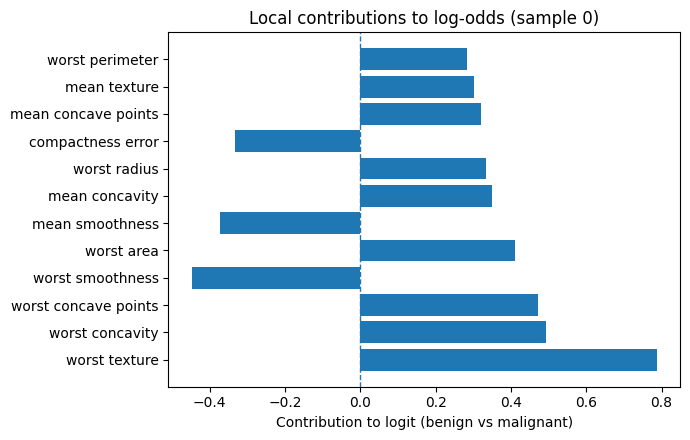


**************************************************
Local plot: bars to the right push toward benign, to the left toward malignant; bar length = contribution magnitude for that specific patient.

**************************************************


In [3]:
import matplotlib.pyplot as plt
import numpy as np

i = 0  # pick a test index to explain
x_std = Xte_s[i]                # standardized features
w     = clf.coef_[0]            # weights (log-odds units)
contrib = x_std * w             # per-feature contribution to the logit
bias = clf.intercept_[0]
logit = bias + contrib.sum()    # logit is the linear score that the logistic regression computes before turning it into a probability with the sigmoid.
prob  = 1/(1+np.exp(-logit))

# sort by absolute contribution
k = 12
idx = np.argsort(np.abs(contrib))[::-1][:k]
feat_names = [X.columns[j] for j in idx]
vals = contrib[idx]

print(f"\nExplaining test sample {i}: logit={logit:.3f}, prob(benign)={prob:.3f}")
print("Top contributions (log-odds):")
for name, v in zip(feat_names, vals):
    sign = "+" if v>=0 else "-"
    print(f"{name:30s} {sign}{abs(v):.4f}")

# bar plot (positive → pushes to benign, negative → pushes to malignant)
plt.figure(figsize=(7, 4.5))
ypos = np.arange(len(vals))
plt.barh(ypos, vals)
plt.yticks(ypos, feat_names)
plt.axvline(0, linestyle="--", linewidth=1)
plt.title(f"Local contributions to log-odds (sample {i})")
plt.xlabel("Contribution to logit (benign vs malignant)")
plt.tight_layout()
plt.show()


print("\n" + 50*"*")
print("Local plot: bars to the right push toward benign, to the left toward malignant; bar length = contribution magnitude for that specific patient.")
print("\n" + 50*"*")


3) L2 vs L1 logistic: sparsity & performance comparison

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# L2 (yours) already trained as `clf`
acc_l2 = accuracy_score(yte, clf.predict(Xte_s))
nz_l2 = int((np.abs(clf.coef_[0]) > 1e-8).sum())

# L1-regularized logistic (sparse weights)
clf_l1 = LogisticRegression(
    penalty="l1", solver="saga", C=0.05,  # tweak C (smaller → sparser)
    max_iter=3000, random_state=0
).fit(Xtr_s, ytr)

acc_l1 = accuracy_score(yte, clf_l1.predict(Xte_s))
nz_l1 = int((np.abs(clf_l1.coef_[0]) > 1e-8).sum())

print(f"\nL2 logistic  → acc={acc_l2:.3f}, nonzero weights={nz_l2}")
print(f"L1 logistic  → acc={acc_l1:.3f}, nonzero weights={nz_l1}")

# show surviving L1 features (sorted by |weight|)
w1 = clf_l1.coef_[0]
idx1 = np.where(np.abs(w1) > 1e-8)[0]
order1 = idx1[np.argsort(np.abs(w1[idx1]))[::-1]]
print("\nTop L1 nonzero weights:")
for j in order1[:15]:
    print(f"{X.columns[j]:30s}  w={w1[j]:+0.4f}")


print("\n" + 50*"*")
print("L1 vs L2: if L1 keeps accuracy close while using fewer non-zero weights, you’ve improved human-interpretability without sacrificing performance.")
print("\n" + 50*"*")



L2 logistic  → acc=0.986, nonzero weights=30
L1 logistic  → acc=0.944, nonzero weights=4

Top L1 nonzero weights:
worst radius                    w=-1.2886
worst concave points            w=-1.1148
mean concave points             w=-0.3556
worst texture                   w=-0.3502

**************************************************
L1 vs L2: if L1 keeps accuracy close while using fewer non-zero weights, you’ve improved human-interpretability without sacrificing performance.

**************************************************


# Important Note:

## How to read the outputs (quick guide)

Permutation importance: features whose shuffling drops accuracy the most are globally important → good fidelity check for your weight ranking.

Local plot: bars to the right push toward benign, to the left toward malignant; bar length = contribution magnitude for that specific patient.

L1 vs L2: if L1 keeps accuracy close while using fewer non-zero weights, you’ve improved human-interpretability without sacrificing performance.

For reliable conclusion perform a small stability test (repeat train with different seeds and compare rank correlations of importances).